In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys

# robot parameters
r = 20.0 #mm
w = 85.0 #mm

# Problem 2(a)
class Node():
    """RRT Node using .parent to keep the info of edges"""
    def __init__(self, state):
        self.state = state
        self.parent = None
        
def find_closestnode(node_list, target_point):
    """ given a set of RRT nodes <node_list> in C-space and a target point <target_point>
    return the closest node to the target point inside the set and the index """
    Closestnode = np.zeros(3)
    Distmin = sys.maxsize
    min_index = sys.maxsize
    for i, node in enumerate(node_list):
        dist = np.linalg.norm(target_point - node.state, ord = 2)
        if dist < Distmin:
            Closestnode = node
            Distmin = dist
            min_index = i
    return Closestnode, min_index

In [2]:
node1 = Node(np.array([2, 2, -2.0]))
node2 = Node(np.array([3, 4, -3.0]))
nodelist = [node1, node2]
Closestnode, min_index = find_closestnode(nodelist, np.array([2, 2, -2.1]))
print(min_index)

0


In [3]:
# Problem 2(b)

# simulation parameters
Kp_rho = 0.3
Kp_alpha = 1.5
Kp_beta = -0.3
dt = 0.1

def trajectory_generation(initial_state, target_state, mode=0):
    """ given initial and target robot states in C-space
    return the smooth trajectory and corresponding control inputs"""
    """
    rho is the distance between the robot and the goal position
    alpha is the angle to the goal relative to the heading of the robot
    beta is the angle between the robot's position and the goal position plus the goal angle
    Kp_rho*rho and Kp_alpha*alpha drive the robot along a line towards the goal
    Kp_beta*beta rotates the line so that it is parallel to the goal angle
    """
    # Initilization
    x_start = initial_state[0]
    y_start = initial_state[1]
    theta_start = initial_state[2]
    x_goal = target_state[0]
    y_goal = target_state[1]
    theta_goal = target_state[2]
    
    x = x_start
    y = y_start
    theta = theta_start
    x_diff = x_goal - x
    y_diff = y_goal - y
    traj = []
    input_traj = []
    rho = np.sqrt(x_diff**2 + y_diff**2)
    
    t = 0

    while (t < 1.0) and (rho > 0.01):
        traj.append(np.array([x, y, theta]))

        x_diff = x_goal - x
        y_diff = y_goal - y

        """
        Restrict alpha and beta (angle differences) to the range
        [-pi, pi] to prevent unstable behavior e.g. difference going
        from 0 rad to 2*pi rad with slight turn
        """

        rho = np.sqrt(x_diff**2 + y_diff**2)
        alpha = (np.arctan2(y_diff, x_diff) -
                 theta + np.pi) % (2 * np.pi) - np.pi
        beta = (theta_goal - theta - alpha + np.pi) % (2 * np.pi) - np.pi

        v = Kp_rho * rho
        omega = Kp_alpha * alpha + Kp_beta * beta
        # Get the control inputs
        omega_right = (2*v + omega*w)/(2*r)
        omega_left = (2*v - omega*w)/(2*r)
        input_traj.append(np.array([omega_left, omega_right]))
        
        if alpha > np.pi / 2 or alpha < -np.pi / 2:
            v = -v

        theta = theta + omega * dt
        x = x + v * np.cos(theta) * dt
        y = y + v * np.sin(theta) * dt
        if mode is 0:
            t += dt
    
    return traj, input_traj

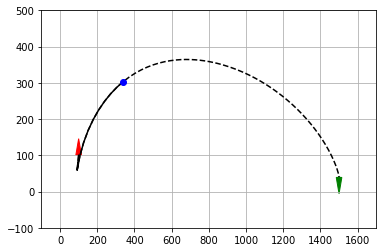

In [23]:
initial_state = np.array([100, 100, np.pi/2])
goal_state = np.array([1500, 40, -np.pi/2])

traj, input_traj = trajectory_generation(initial_state, goal_state, mode =0)
traj_all, input_traj = trajectory_generation(initial_state, goal_state, mode =1)
plt.figure()
plt.arrow(initial_state[0], initial_state[1], np.cos(initial_state[2]),
          np.sin(initial_state[2]), color='r', width=10)
plt.arrow(goal_state[0], goal_state[1], np.cos(goal_state[2]),
          np.sin(goal_state[2]), color='g', width=10)
traj_array = np.reshape(traj, [len(traj), 3])
traj_array_all = np.reshape(traj_all, [len(traj_all), 3])
plt.plot(traj_array[:,0], traj_array[:,1],'-k')
plt.plot(traj_array_all[:,0], traj_array_all[:,1],'--k')
plt.plot(traj_array[-1,0], traj_array[-1,1],'bo')
plt.ylim([-100, 500])
plt.xlim([-100, 1700])
plt.grid()
plt.show()

In [9]:
# Problem 2(c)
from scipy.spatial import ConvexHull
from scipy.spatial import convex_hull_plot_2d
from numpy import cos, sin

def draw_Ospace(initial_state, goal_state, obstaclelist):
    """ obstaclelist includes all obstacle infos 
    each obstacle (x, y, width, height) in which (x,y) is the left and bottom 
    coordinate of the rectangle and (width, height) is the range of the obstacle"""
    
    fig = plt.figure(figsize = (9, 6))
    ax = fig.add_subplot(1,1,1)
    plt.xlim((0, 1800))
    plt.ylim((0, 1200))
    plt.grid()
    
    # Plot initial (red) and goal (green) states
    plt.arrow(initial_state[0], initial_state[1], np.cos(initial_state[2]),
              np.sin(initial_state[2]), color='r', width=10)
    plt.arrow(goal_state[0], goal_state[1], np.cos(goal_state[2]),
              np.sin(goal_state[2]), color='g', width=10)
              
    # Plot the obstacles
    for ob in obstaclelist:
        obstacle = plt.Rectangle(ob[0:2], ob[2], ob[3], color = 'k')
        ax.add_patch(obstacle)
    return ax
        
def draw_Cspace(initial_state, goal_state, obstaclelist):
    """ translate the previous Ospace map into Cspace map using ConvexHull to
    form the C-space obstacles"""
    
    fig = plt.figure(figsize = (12, 8))
    #ax = fig.gca()
    ax = fig.gca(projection='3d')
    ax.set_xlim([0, 1800])
    ax.set_ylim([0, 1200])
    ax.view_init(elev=60)
    Cspace_obstacle = {}
    for ob in obstaclelist: 
        theta_sample = np.linspace(-np.pi, np.pi, 100)
        points = []
        for theta in theta_sample:
            A = [[ob[0], ob[1], theta], [ob[0]+ob[2], ob[1], theta],
                 [ob[0], ob[1]+ob[3], theta], [ob[0]+ob[2], ob[1]+ob[3], theta]]
            for a in A:
                vertice1 = [a[0]+70*cos(theta)+42.5*cos(theta-np.pi/2),
                            a[1]+70*sin(theta)+42.5*sin(theta-np.pi/2), theta]
                vertice2 = [a[0]+70*cos(theta)+42.5*cos(theta+np.pi/2),
                            a[1]+70*sin(theta)+42.5*sin(theta+np.pi/2), theta]
                vertice3 = [a[0]+10*cos(theta+np.pi)+42.5*cos(theta-np.pi/2),
                            a[1]+10*sin(theta+np.pi)+42.5*sin(theta-np.pi/2), theta]
                vertice4 = [a[0]+10*cos(theta+np.pi)+42.5*cos(theta+np.pi/2),
                            a[1]+10*sin(theta+np.pi)+42.5*sin(theta+np.pi/2), theta]
                points.append(a)
                points.append(vertice1)
                points.append(vertice2)
                points.append(vertice3)
                points.append(vertice4)

        points = np.array(points)
        hull= ConvexHull(points)
        for i in hull.simplices:
            plt.plot(points[i,0], points[i,1], points[i,2], 'k-')
        Cspace_obstacle[ob] = hull
    ax.scatter(initial_state[0], initial_state[1], initial_state[2],
              c = 'r', marker ='o', s=100)
    ax.scatter(goal_state[0], goal_state[1], goal_state[2],
               c = 'g', marker ='o', s=100)
    plt.grid()
    plt.axis('equal')
    plt.show()        
    return Cspace_obstacle

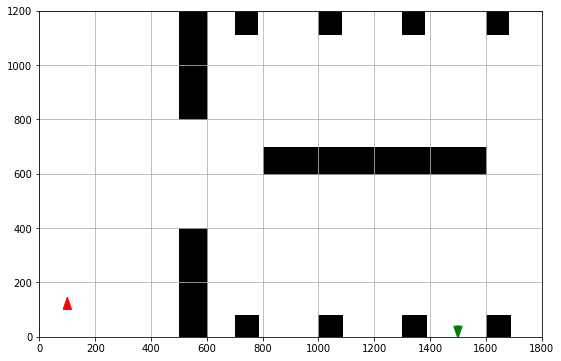

In [10]:
obstaclelist=[
    (500, 800, 100, 400),
    (500, 0, 100, 400),
    (700, 0, 85, 80),
    (1000, 0, 85, 80),
    (1300, 0, 85, 80),
    (1600, 0, 85, 80),
    (800, 600, 800, 100),
    (700, 1115, 80, 85),
    (1000, 1115, 80, 85),
    (1300, 1115, 80, 85),
    (1600, 1115, 80, 85)
    ]
initial_state = np.array([100, 100, np.pi/2])
goal_state = np.array([1500, 40, -np.pi/2])

ax = draw_Ospace(initial_state, goal_state, obstaclelist)

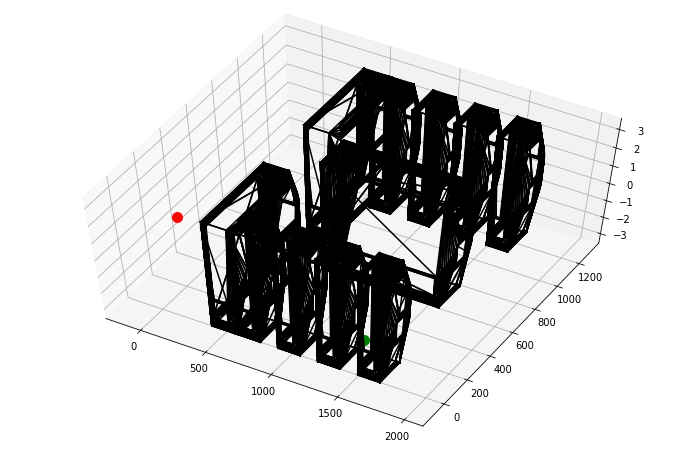

In [11]:
Cspace_ob = draw_Cspace(initial_state, goal_state, obstaclelist)

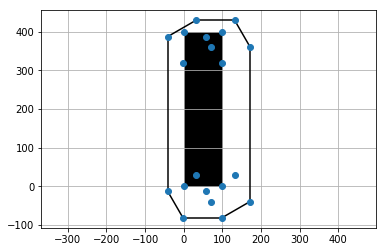

In [12]:
A = np.array([[0, 0], [100, 0], [0, 400], [100, 400]])
theta = -np.pi/3
robot_vertice = []
for a in A:
    vertice1 = [a[0]+70*cos(theta)+42.5*cos(theta-np.pi/2),
                        a[1]+70*sin(theta)+42.5*sin(theta-np.pi/2)]
    vertice2 = [a[0]+70*cos(theta)+42.5*cos(theta+np.pi/2),
                        a[1]+70*sin(theta)+42.5*sin(theta+np.pi/2)]
    vertice3 = [a[0]+10*cos(theta+np.pi)+42.5*cos(theta-np.pi/2),
                        a[1]+10*sin(theta+np.pi)+42.5*sin(theta-np.pi/2)]
    vertice4 = [a[0]+10*cos(theta+np.pi)+42.5*cos(theta+np.pi/2),
                        a[1]+10*sin(theta+np.pi)+42.5*sin(theta+np.pi/2)]
    robot_vertice.append(vertice1)
    robot_vertice.append(vertice2)
    robot_vertice.append(vertice3)
    robot_vertice.append(vertice4)
B = np.concatenate((A, robot_vertice))
hull2 = ConvexHull(B)
fig2 = convex_hull_plot_2d(hull2)
ax = fig2.gca()
ob = plt.Rectangle([0, 0], 100, 400, color = 'k')
ax.add_patch(ob)
plt.grid()
plt.axis('equal')
plt.show()

In [13]:
# Problem 2(d)
def is_traj_collisionfree(traj, Cspace_obstacles):
    """ Given a trajectory in C-space and the C-space obstacles
    determine whether each sample point 
    along this trajectory is outside any obstacle
    Note: Cspace_obstacles is a dir where <ob:ConvexHull>
    """
    collision_free = True
    # for each sample point
    for pnt in traj:
        # for each convex hull representing the C-space obstacle
        for ob in Cspace_obstacles.keys():
            hull = Cspace_obstacles[ob]
            # Form the new hull adding the point of the taj
            new_hull = ConvexHull(np.concatenate((hull.points, [pnt])))
            # If the hull not changed, indicate this point is inside this hull
            if np.array_equal(new_hull.vertices, hull.vertices):
                collision_free = False
    return collision_free

In [14]:
# Problem 2(e)
import random

def rrt_planner(initial_state, goal_state, sample_boundary, max_step=2000):
    """ Args:
    initial_state - initial position and heading angle.
    goal_state - goal position and heading angle.
    sample_boundary - the random sample should be within this boundary.
    max_step - the max number of step to avoid infinite loop.
    this function will use RRT algorithm and return a traj
    as a list [[x0,y0,theta0],..., [xg,yg,thetag]]
    """
    print("Using RRT algorithm !!!")
    start_node = Node(initial_state)
    end_node = Node(goal_state)
    nodelist = [start_node]
    step = 0
    reach_goal = False
    np.random.seed(10)
    
    while step <= max_step:
        # Whether can reach the goal
        close_to_goal = np.linalg.norm(goal_state - nodelist[-1].state.copy(), ord = 2)
        if close_to_goal < 100:
            reach_goal = True
            break
        # Sample a random point
        pnt_random = np.zeros(3)
        
        for i in range(3):
            pnt_random[i] = np.random.uniform(sample_boundary[i][0], sample_boundary[i][1])
        step += 1
        
        # Find nearest node
        nearestNode, min_index = find_closestnode(nodelist, pnt_random)
        # expand tree
        traj_temp, _ = trajectory_generation(nearestNode.state.copy(), pnt_random, mode=0)
        if is_traj_collisionfree(traj_temp, Cspace_ob):
            newNode = Node(traj_temp[-1])
            newNode.parent = min_index
            nodelist.append(newNode)
        print("nNodelist:", len(nodelist))
    
    # Find the path with all via points
    path = [goal_state]
    lastIndex = len(nodelist) - 1
    while nodelist[lastIndex].parent is not None:
        node = nodelist[lastIndex]
        path.append(node.state)
        lastIndex = node.parent
    path.append(initial_state)
    
    # Generate the traj
    traj = []
    i = len(path) - 1
    while i >= 1:
        traj_temp, _ = trajectory_generation(path[i], path[i-1], mode=1)
        traj = traj + traj_temp
        i = i - 1
    return traj, path

In [16]:
initial_state = np.array([100, 100, np.pi/2])
goal_state = np.array([1500, 40, -np.pi/2])
#goal_state = np.array([500, 600, 0.0])
sample_boundary = [(0, 1800), (0, 1200), (-np.pi, np.pi)]
traj, path = rrt_planner(initial_state, goal_state, sample_boundary, max_step=2000)

Using RRT algorithm !!!
nNodelist: 2
nNodelist: 2
nNodelist: 2
nNodelist: 2
nNodelist: 3
nNodelist: 3
nNodelist: 3
nNodelist: 4
nNodelist: 4
nNodelist: 5
nNodelist: 5
nNodelist: 5
nNodelist: 6
nNodelist: 7
nNodelist: 7
nNodelist: 7
nNodelist: 8
nNodelist: 9
nNodelist: 10
nNodelist: 11
nNodelist: 12
nNodelist: 12
nNodelist: 13
nNodelist: 13
nNodelist: 14
nNodelist: 15
nNodelist: 16
nNodelist: 17
nNodelist: 17
nNodelist: 18
nNodelist: 19
nNodelist: 19
nNodelist: 19
nNodelist: 20
nNodelist: 21
nNodelist: 21
nNodelist: 22
nNodelist: 23
nNodelist: 24
nNodelist: 25
nNodelist: 26
nNodelist: 26
nNodelist: 27
nNodelist: 28
nNodelist: 29
nNodelist: 29
nNodelist: 30
nNodelist: 30
nNodelist: 31
nNodelist: 32
nNodelist: 32
nNodelist: 32
nNodelist: 33
nNodelist: 33
nNodelist: 34
nNodelist: 34
nNodelist: 35
nNodelist: 35
nNodelist: 35
nNodelist: 36
nNodelist: 37
nNodelist: 38
nNodelist: 38
nNodelist: 38
nNodelist: 39
nNodelist: 39
nNodelist: 39
nNodelist: 39
nNodelist: 39
nNodelist: 39
nNodelist: 40


In [15]:
def draw_robot(traj):
    start = traj[0]
    end = traj[-1]
    ax = draw_Ospace(start, end, obstaclelist)

    for pnt in traj:
        theta = pnt[2]
        rec_corner = [pnt[0]+70*cos(theta+np.pi)+42.5*cos(theta-np.pi/2),
                      pnt[1]+70*sin(theta+np.pi)+42.5*sin(theta-np.pi/2)]
        robot = plt.Rectangle(rec_corner, 80, 85, np.degrees(theta), facecolor='w', edgecolor='b')
        ax.add_patch(robot)

    plt.show()

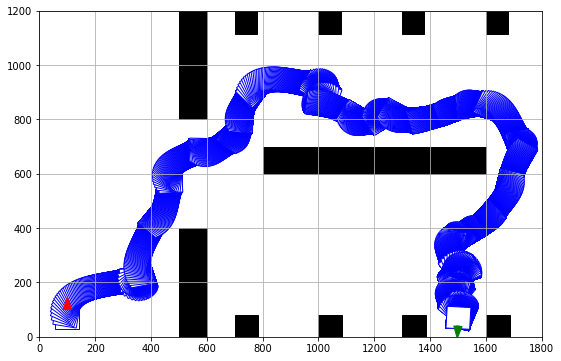

In [17]:
# head-in parking
draw_robot(traj)

In [18]:
def rrt_planner2(initial_state, goal_state, sample_boundary, max_step=2000):
    """ Args:
    initial_state - initial position and heading angle.
    goal_state - goal position and heading angle.
    sample_boundary - the random sample should be within this boundary.
    max_step - the max number of step to avoid infinite loop.
    this function will use RRT algorithm and return a traj
    as a list [[x0,y0,theta0],..., [xg,yg,thetag]]
    """
    print("Using RRT algorithm !!!")
    start_node = Node(initial_state)
    end_node = Node(goal_state)
    nodelist = [start_node]
    step = 0
    reach_goal = False
    np.random.seed(10)
    
    while step <= max_step:
        # Whether can reach the goal
        traj_temp, _ = trajectory_generation(nodelist[-1].state.copy(), goal_state, mode=1)
        if is_traj_collisionfree(traj_temp, Cspace_ob):
            reach_goal = True
            break
        # Sample a random point
        pnt_random = np.zeros(3)
        
        for i in range(3):
            pnt_random[i] = np.random.uniform(sample_boundary[i][0], sample_boundary[i][1])
        step += 1
        
        # Find nearest node
        nearestNode, min_index = find_closestnode(nodelist, pnt_random)
        # expand tree
        traj_temp, _ = trajectory_generation(nearestNode.state.copy(), pnt_random, mode=0)
        if is_traj_collisionfree(traj_temp, Cspace_ob):
            newNode = Node(traj_temp[-1])
            newNode.parent = min_index
            nodelist.append(newNode)
        print("nNodelist:", len(nodelist))
    
    # Find the path with all via points
    path = [goal_state]
    lastIndex = len(nodelist) - 1
    while nodelist[lastIndex].parent is not None:
        node = nodelist[lastIndex]
        path.append(node.state)
        lastIndex = node.parent
    path.append(initial_state)
    
    # Generate the traj
    traj = []
    i = len(path) - 1
    while i >= 1:
        traj_temp, _ = trajectory_generation(path[i], path[i-1], mode=1)
        traj = traj + traj_temp
        i = i - 1
    return traj, path

In [36]:
initial_state = np.array([100, 100, np.pi/2])
goal_state = np.array([1500, 40, -np.pi/2])
#goal_state = np.array([500, 600, 0.0])
sample_boundary = [(0, 1800), (0, 1200), (-np.pi, np.pi)]
traj2, path2 = rrt_planner2(initial_state, goal_state, sample_boundary, max_step=2000)

Using RRT algorithm !!!
nNodelist: 2
nNodelist: 2
nNodelist: 2
nNodelist: 2
nNodelist: 3
nNodelist: 3
nNodelist: 3
nNodelist: 4
nNodelist: 4
nNodelist: 5


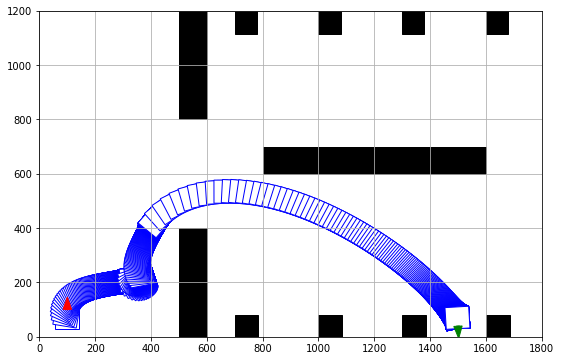

In [37]:
# Plot the trajectory with robot visulization
draw_robot(traj2)

In [38]:
initial_state = np.array([100, 100, np.pi/2])
goal_state = np.array([1200, 1160, 0])
#goal_state = np.array([500, 600, 0.0])
sample_boundary = [(0, 1800), (0, 1200), (-np.pi, np.pi)]
traj3, path3 = rrt_planner2(initial_state, goal_state, sample_boundary, max_step=2000)

Using RRT algorithm !!!
nNodelist: 2
nNodelist: 2
nNodelist: 2
nNodelist: 2
nNodelist: 3
nNodelist: 3
nNodelist: 3
nNodelist: 4
nNodelist: 4
nNodelist: 5
nNodelist: 5
nNodelist: 5
nNodelist: 6
nNodelist: 7
nNodelist: 7
nNodelist: 7
nNodelist: 8
nNodelist: 9
nNodelist: 10
nNodelist: 11
nNodelist: 12
nNodelist: 12
nNodelist: 13
nNodelist: 13
nNodelist: 14
nNodelist: 15
nNodelist: 16


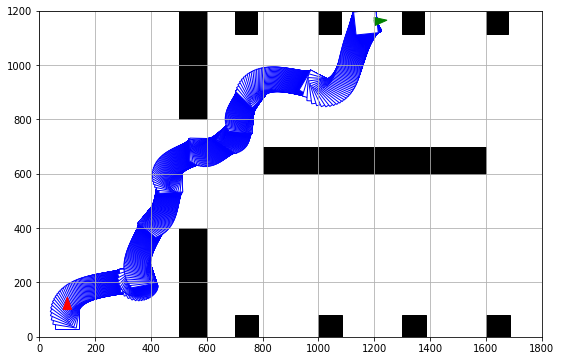

In [39]:
# Parrallel parking
draw_robot(traj3)